In [326]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [390]:
def plot_heatmap(data, row_labels, col_labels, title="Heatmap", cmap="coolwarm"):
    """
    Plots a heatmap using seaborn.

    Parameters:
    - data: 2D NumPy array or list of lists (heatmap values)
    - row_labels: List of row labels
    - col_labels: List of column labels
    - title: Title of the heatmap (default: "Heatmap")
    - cmap: Colormap (default: "coolwarm")

    Returns:
    - Displays a heatmap
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(data, annot=True, fmt=".1f", cmap=cmap, xticklabels=col_labels, yticklabels=row_labels)
    plt.title(title)
    plt.xlabel("Opponent Strategy")
    plt.ylabel("Player Strategy")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.show()


def plot_heatmap_with_variance(mean_data, variance_data, row_labels, col_labels, title="Heatmap with Variance", cmap="coolwarm"):
    """
    Plots a heatmap using seaborn, displaying both mean values and variance annotations.

    Parameters:
    - mean_data: 2D NumPy array or list of lists containing the mean values.
    - variance_data: 2D NumPy array or list of lists containing the variance values.
    - row_labels: List of row labels (strategy names for rows).
    - col_labels: List of column labels (strategy names for columns).
    - title: Title of the heatmap (default: "Heatmap with Variance").
    - cmap: Colormap (default: "coolwarm").

    Returns:
    - Displays a heatmap with variance annotations.
    """
    plt.figure(figsize=(12, 10))
    
    # Create annotation text with mean ± variance
    annotations = np.array([
        [f"{mean:.1f}\n ± {var:.1f}" for mean, var in zip(mean_row, var_row)]
        for mean_row, var_row in zip(mean_data, variance_data)
    ])
    
    # Plot heatmap
    ax = sns.heatmap(mean_data, annot=annotations, fmt="", cmap=cmap, xticklabels=col_labels, yticklabels=row_labels)
    
    plt.title(title)
    plt.xlabel("Opponent Strategy")
    plt.ylabel("Player Strategy")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.show()

In [3]:
def play_ipd(strategy_A, strategy_B, rounds=10):
    """
    Plays an Iterated Prisoner's Dilemma game.

    Parameters:
    - strategy_A: Function that takes (own_history, opponent_history) and returns 'C' or 'D'.
    - strategy_B: Function that takes (own_history, opponent_history) and returns 'C' or 'D'.
    - rounds: Number of rounds to play.

    Returns:
    - history_A: List of Agent A's actions.
    - history_B: List of Agent B's actions.
    - scores_A: Total score of Agent A.
    - scores_B: Total score of Agent B.
    """

    # Reward matrix
    rewards = {
        ('C', 'C'): (3, 3),
        ('C', 'D'): (0, 5),
        ('D', 'C'): (5, 0),
        ('D', 'D'): (1, 1)
    }

    # Initialize history
    history_A = []
    history_B = []
    scores_A = 0
    scores_B = 0

    for _ in range(rounds):
        # Get actions from both strategies
        action_A = strategy_A(history_A, history_B)
        action_B = strategy_B(history_B, history_A)

        # Ensure actions are valid
        if action_A not in ['C', 'D'] or action_B not in ['C', 'D']:
            raise ValueError("Strategies must return 'C' or 'D'")

        # Store actions
        history_A.append(action_A)
        history_B.append(action_B)

        # Assign scores
        score_A, score_B = rewards[(action_A, action_B)]
        scores_A += score_A
        scores_B += score_B

    return history_A, history_B, scores_A, scores_B

In [317]:
def history_to_vector(history):
    vector = []
    for action in history:
        if action == 'D':
            vector.append(1e-10)
        elif action == 'C':
            vector.append(1)
    return np.array(vector)

In [320]:
def tit_for_tat(my_history, opponent_history):
    """Cooperate on the first move, then mimic the opponent's last move."""
    return 'C' if not opponent_history else opponent_history[-1]

def always_defect(my_history, opponent_history):
    """Always defect."""
    return 'D'

def always_cooperate(my_history, opponent_history):
    """Always cooperate."""
    return 'C'

def random_strategy(my_history, opponent_history):
    """Randomly cooperates or defects."""
    random.seed()
    return random.choice(['C', 'D'])

def grudger(my_history, opponent_history):
    """Cooperates unless opponent defects once, then always defects."""
    return 'D' if 'D' in opponent_history else 'C'

def pavlov(my_history, opponent_history):
    """Cooperates if last round was mutual cooperation or mutual defection, otherwise switches."""
    if not my_history:  # First move
        return 'C'
    if my_history[-1] == opponent_history[-1]:  # If both did the same last round
        return my_history[-1]  # Repeat the move
    return 'D' if my_history[-1] == 'C' else 'C'  # Switch otherwise

def adaptive_majority(my_history, opponent_history):
    """Counts past moves and plays majority-based strategy."""
    if not opponent_history:
        return 'C'
    return 'C' if opponent_history.count('C') > opponent_history.count('D') else 'D'

def tit_for_two_tats(my_history, opponent_history):
    """Cooperates unless opponent defects twice in a row."""
    if len(opponent_history) >= 2 and opponent_history[-2:] == ['D', 'D']:
        return 'D'
    return 'C'

def deterministic_random(my_history, opponent_history):
    random.seed(a=len(my_history))
    return random.choice(['C', 'D'])

In [343]:
def shadow_tit_for_tat(my_history, opponent_history):
    """A deceptive but adaptive strategy that initially plays Tit-for-Tat,
       then selectively punishes frequent defectors while occasionally exploiting cooperators."""
    
    # First move is always cooperation
    if not opponent_history:
        return 'C'
    
    rounds_played = len(opponent_history)
    
    # Play Tit-for-Tat for the first 5 rounds
    if rounds_played < 5:
        return opponent_history[-1] if opponent_history else 'C'
    
    # Count how many times opponent has defected
    num_defections = opponent_history.count('D')
    defection_rate = num_defections / rounds_played
    
    # If opponent defects more than 40% of the time, switch to full defection mode
    if defection_rate > 0.4:
        return 'D'
    
    # Occasionally defect (every 7-10 rounds randomly) against naive cooperators
    if rounds_played % random.randint(7, 10) == 0:
        return 'D'
    
    # If opponent punishes us for defecting, return to Tit-for-Tat mode
    if len(my_history) > 1 and my_history[-1] == 'D' and opponent_history[-1] == 'D':
        return 'C'
    
    # If opponent has cooperated 5 times in a row, reset punishment mechanism
    if len(opponent_history) >= 5 and opponent_history[-5:] == ['C'] * 5:
        return 'C'
    
    # Default to Tit-for-Tat behavior
    return opponent_history[-1]

def forgiving_opportunist(my_history, opponent_history):
    """A strategy that cooperates, forgives one defect, but punishes repeated defections.
       Occasionally defects to avoid exploitation."""
    
    # First move is always cooperation
    if not opponent_history:
        return 'C'
    
    # 10% chance to defect randomly to avoid exploitation
    if random.random() < 0.1:
        return 'D'
    
    # If opponent defected twice in the last 3 rounds, retaliate
    if opponent_history[-3:].count('D') >= 2:
        return 'D'
    
    # If opponent cooperated 3 times in a row, reset & forgive
    if opponent_history[-3:] == ['C', 'C', 'C']:
        return 'C'
    
    # If opponent defected once, forgive them
    if opponent_history[-1] == 'D':
        return 'C'
    
    # Otherwise, cooperate
    return 'C'

def pattern_aware_opportunist(my_history, opponent_history):
    """An opportunistic strategy that detects opponent patterns, adapts to defectors, 
       and occasionally exploits naive strategies."""
    
    # First two moves are always cooperation
    if len(opponent_history) < 2:
        return 'C'
    
    # Count defections in the last 4 rounds
    recent_defections = opponent_history[-4:].count('D')
    
    # If opponent defects twice within 4 rounds, retaliate
    if recent_defections >= 2:
        return 'D'
    
    # Detect "C-D-C-D" alternating pattern and defect to break it
    if len(opponent_history) >= 4 and opponent_history[-4:] == ['C', 'D', 'C', 'D']:
        return 'D'
    
    # If opponent plays "D-D-D", respond with three rounds of defection
    if len(opponent_history) >= 3 and opponent_history[-3:] == ['D', 'D', 'D']:
        return 'D'
    
    # If opponent has cooperated 5 times in a row, reset and forgive
    if len(opponent_history) >= 5 and opponent_history[-5:] == ['C'] * 5:
        return 'C'
    
    # Occasionally defect every 6-10 rounds to maximize points
    if len(my_history) % random.randint(6, 10) == 0:
        return 'D'
    
    # Default to cooperation
    return 'C'


def deceptive_caretaker(my_history, opponent_history):
    """A deceptive but adaptive strategy that extracts points from naive cooperators,
       punishes aggressive defectors, and strategically forgives after testing trust."""
    
    # First move is always cooperation
    if not opponent_history:
        return 'C'
    
    rounds_played = len(opponent_history)
    coop_count = opponent_history.count('C')
    coop_rate = coop_count / rounds_played if rounds_played > 0 else 1.0  # Prevent division by zero
    
    # If opponent cooperates more than 70% of the time, occasionally defect to maximize points
    if coop_rate > 0.7 and rounds_played % random.randint(6, 9) == 0:
        return 'D'
    
    # If opponent defects more than 50% of the time, retaliate by always defecting
    if coop_rate < 0.5:
        return 'D'
    
    # If opponent defects twice in a row, punish with 3 defections
    if len(opponent_history) >= 2 and opponent_history[-2:] == ['D', 'D']:
        return 'D'
    
    # If opponent shows sudden cooperation after defecting a lot, test trust before forgiving
    if len(opponent_history) >= 3 and opponent_history[-3:] == ['C', 'C', 'C']:
        return 'C'
    
    # Fake "peace offering": Cooperate once after defecting to see if opponent gets baited into cooperating
    if len(my_history) >= 2 and my_history[-1] == 'D' and opponent_history[-1] == 'C':
        return 'C'
    
    # 5% chance to defect randomly to prevent exploitation
    if random.random() < 0.05:
        return 'D'
    
    # Default to cooperation
    return 'C'

In [344]:
baseline_policies = [deterministic_random, tit_for_tat, always_defect, always_cooperate, random_strategy, grudger, pavlov, adaptive_majority, tit_for_two_tats]
generated_policies = [shadow_tit_for_tat, forgiving_opportunist, pattern_aware_opportunist, deceptive_caretaker]
all_policies = baseline_policies + generated_policies

In [345]:
labels = ['deterministic_random', 'tit_for_tat', 'always_defect', 'always_cooperate', 'random_strategy', 'grudger', 'pavlov', 'adaptive_majority', 'tit_for_two_tats', 'shadow_tit_for_tat', 'forgiving_opportunist', 'pattern_aware_opportunist', 'deceptive_caretaker']

In [416]:
%%time
cos_sim = 0
rounds = 200
N = 100
score_matrix = np.zeros((N, len(all_policies), len(all_policies)))
cosine_matrix = np.zeros((N, len(all_policies), len(all_policies)))
for n in range(N):
    for i, policy_a in enumerate(all_policies):
        for j, policy_b in enumerate(all_policies):
            history_A, history_B, score_A, score_B = play_ipd(policy_a, policy_b, rounds=rounds)
            a = history_to_vector(history_A)
            b = history_to_vector(history_B)
            score_matrix[n, i, j] += score_A
            cosine_matrix[n, i, j] += np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

CPU times: user 7.94 s, sys: 1.78 s, total: 9.72 s
Wall time: 9.72 s


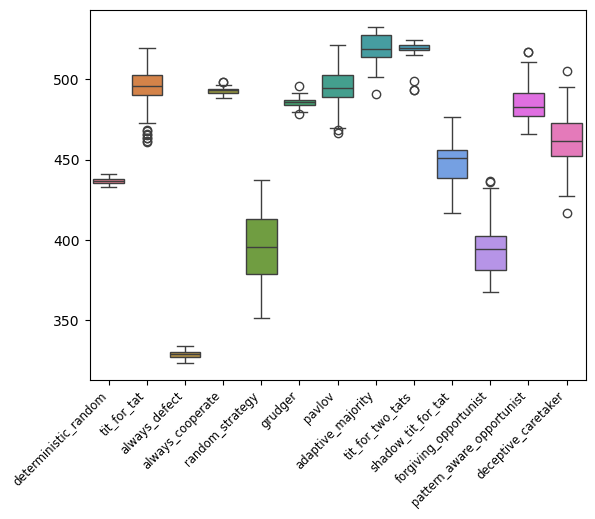

In [417]:
sns.boxplot(score_matrix.mean(axis=2))
plt.xticks(range(len(labels)), labels, size='small', rotation=45, ha="right");

'always_cooperate'

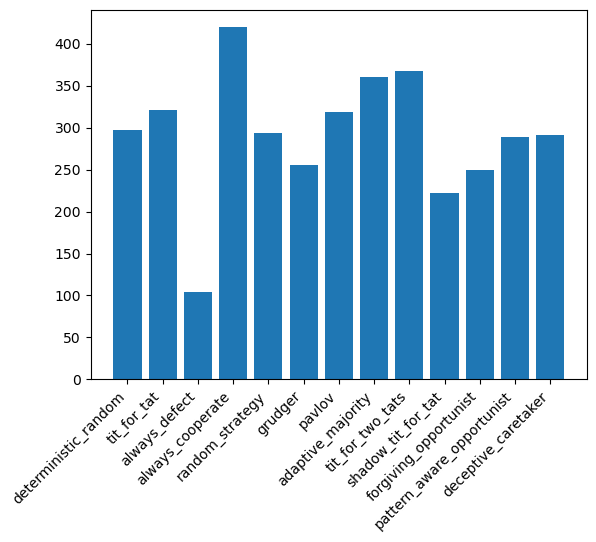

In [386]:
plt.bar(labels, score_matrix.mean(axis=(0, 1)))
plt.xticks(rotation=45, ha="right");
labels[score_matrix.mean(axis=(0, 1)).argmax()]

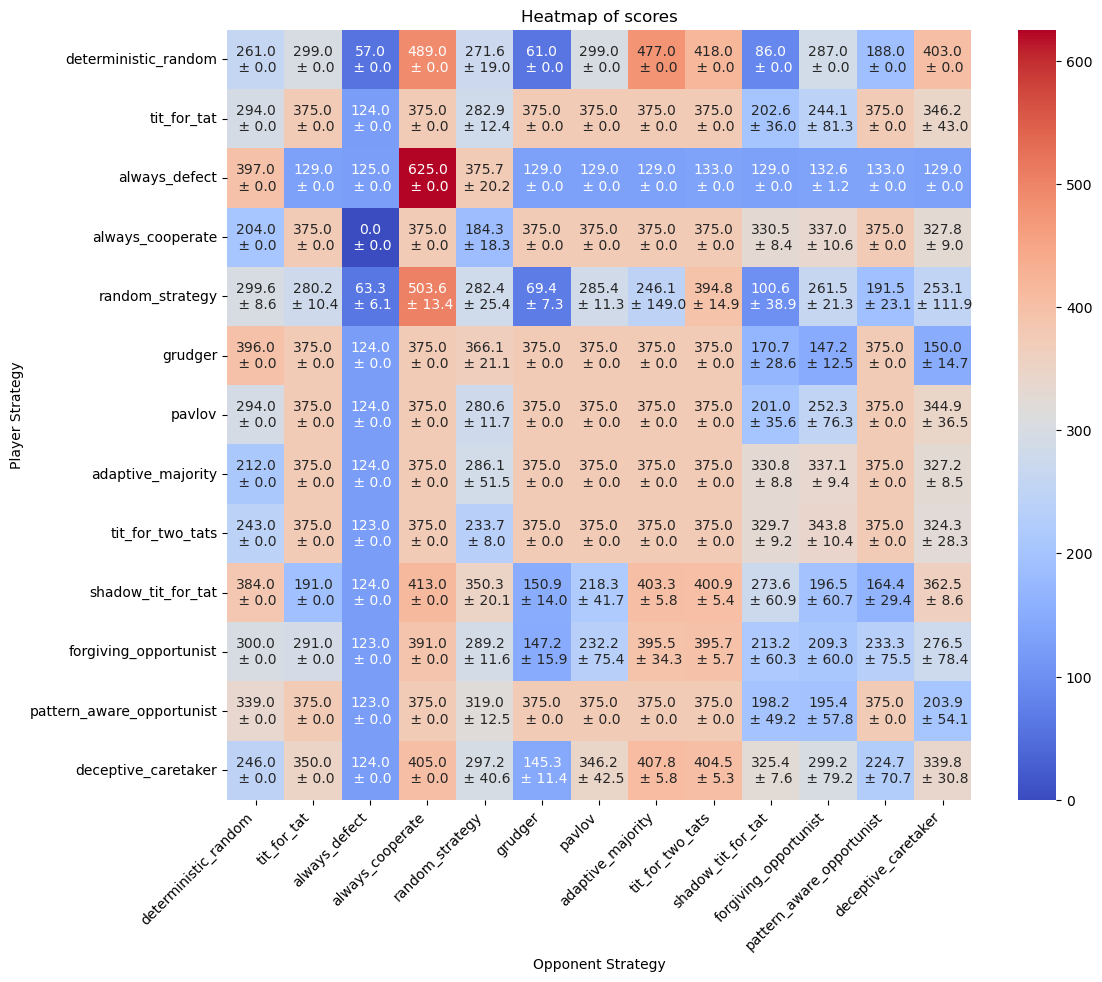

In [391]:
plot_heatmap_with_variance(score_matrix.mean(axis=0), score_matrix.std(axis=0), labels, labels, 'Heatmap of scores')

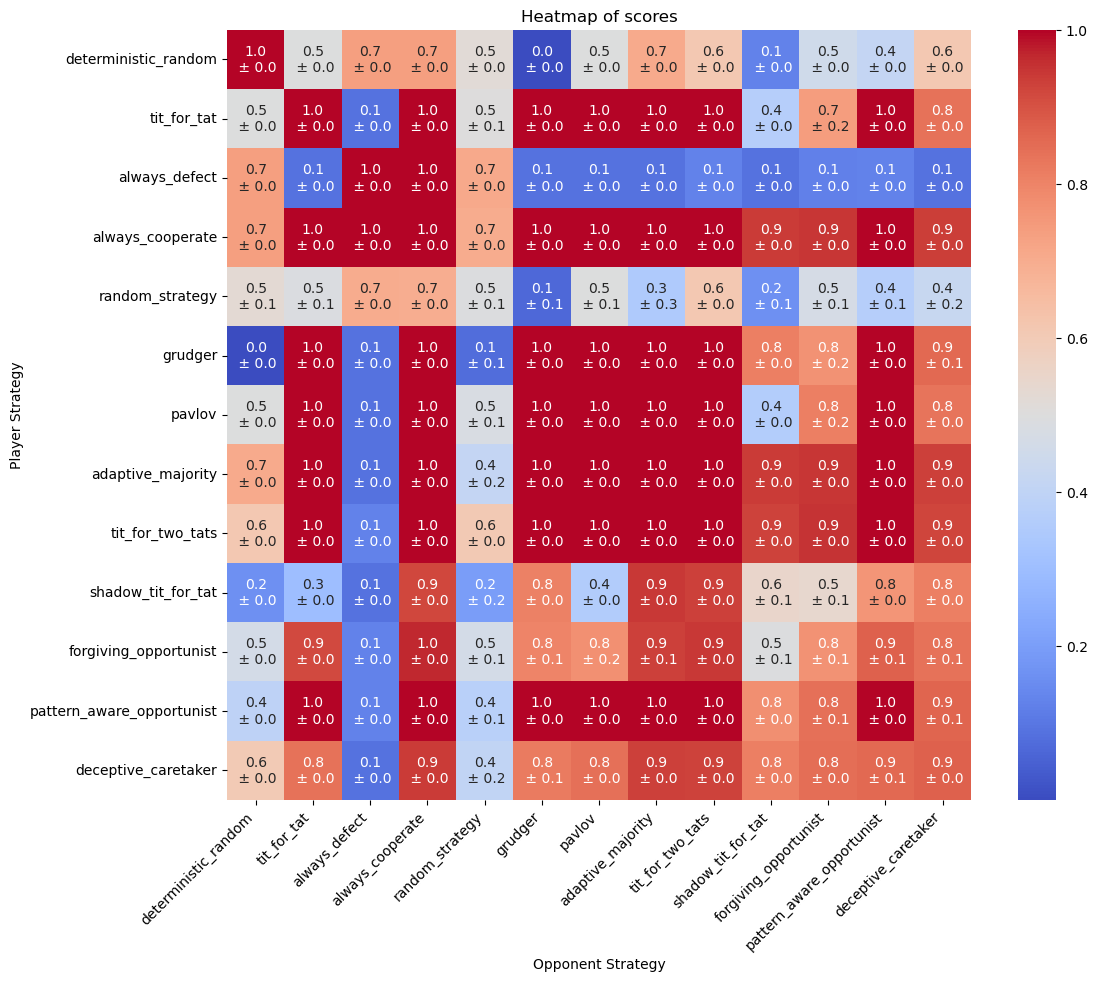

In [392]:
plot_heatmap_with_variance(cosine_matrix.mean(axis=0), cosine_matrix.std(axis=0), labels, labels, 'Heatmap of scores')